---
title: "DLOmix embedding of Prosit model on ProteomeTools data"

date: last-modified

author:

- name: Tobias Greisager Rehfeldt

  orcid: 0000-0002-1190-9485

  affiliations:
    - University of Southern Denmark, Odense
    - Department of Natural Science, Institute for Mathematics and Computer Science

---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ProteomicsML/ProteomicsML/blob/main/tutorials/retentiontime/_dlomix-prosit-rt.ipynb)


In [ ]:
 %%capture
!pip install pandas sklearn tensorflow dlomix numpy matplotlib requests

In [ ]:
# Import and normalize/standarize data
import pandas as pd
import numpy as np
# Import and normalize the data
data = pd.read_csv('https://github.com/ProteomicsML/ProteomicsML/blob/main/datasets/retentiontime/ProteomeTools/Small.csv.gz?raw=true', compression='gzip')

# shuffle and split dataset into internal (80%) and external (20%) datasets
data = data.sample(frac=1)
test_data = data[int(len(data)*0.8):]
data = data[:int(len(data)*0.8)]

In [ ]:
# Split the internal dataset into training and validation
# We have to split the data based on Sequences, to make sure we dont have cross-over sequences in the training and validation splits.
unique_sequences = list(set(data['Sequence']))
# Shuffle the data to ensure unbiased data splitting
from random import shuffle
shuffle(unique_sequences)
# Split sequence 80-10-10 training, validation and testing split
train = unique_sequences[0:int(len(unique_sequences) * 0.8)]
validation = unique_sequences[int(len(unique_sequences) * 0.8):]
# Transfer the sequence split into data split
train = data[data['Sequence'].isin(train)]
validation = data[data['Sequence'].isin(validation)]
print('Training data points:', len(train),'  Validation data points:',  len(validation),'  Testing data points:',  len(test_data))
# Here we use test as an external dataset unlike the one used for training.

Training data points: 63220   Validation data points: 16780   Testing data points: 20000


In [ ]:
normalize = True
if normalize:
  # Normalize
  train_val_min, train_val_max = min(train['Retention time'].min(), validation['Retention time'].min()), max(train['Retention time'].max(), validation['Retention time'].max())
  train['Retention time'] = list((train['Retention time'] - train_val_min) / (train_val_max - train_val_min))
  validation['Retention time'] = list((validation['Retention time'] - train_val_min) / (train_val_max - train_val_min))
  test_data['Retention time'] = list((test_data['Retention time'] - test_data['Retention time'].min()) / (test_data['Retention time'].max() - test_data['Retention time'].min()))
else:
  # Standardize
  train_val_mean, train_val_std = np.mean(list(train['Retention time']) + list(validation['Retention time'])), np.std(list(train['Retention time']) + list(validation['Retention time']))
  train['Retention time'] = (train['Retention time'] - train_val_mean) / train_val_std
  validation['Retention time'] = (validation['Retention time'] - train_val_mean) / train_val_std
  test_data['Retention time'] = (test_data['Retention time'] - np.mean(test_data['Retention time'])) / np.std(test_data['Retention time'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Setup parameters
sequence_length = 30
batch_size = 64
epochs=5

In [ ]:
# Setup data 
from dlomix.data import RetentionTimeDataset
train_input = RetentionTimeDataset(data_source=tuple([np.array(train['Sequence']), np.array(train['Retention time'])]), 
                                        seq_length=sequence_length, batch_size=batch_size, test=False).train_data

val_input = RetentionTimeDataset(data_source=tuple([np.array(validation['Sequence']), np.array(validation['Retention time'])]), 
                                        seq_length=sequence_length, batch_size=batch_size, test=False).train_data

test_input = RetentionTimeDataset(data_source=tuple([np.array(test_data['Sequence']), np.array(test_data['Retention time'])]), 
                                        seq_length=sequence_length, batch_size=batch_size, test=False).train_data

# Setup PROSIT model from DLOmix
from dlomix.models.prosit import PrositRetentionTimePredictor
model = PrositRetentionTimePredictor(seq_length=sequence_length)
model.build((None, sequence_length))
model.summary()

Model: "prosit_retention_time_predictor_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 string_lookup_2 (StringLook  multiple                 0         
 up)                                                             
                                                                 
 embedding_2 (Embedding)     multiple                  352       
                                                                 
 sequential_4 (Sequential)   (None, 30, 512)           1996800   
                                                                 
 attention_layer_2 (Attentio  multiple                 542       
 nLayer)                                                         
                                                                 
 sequential_5 (Sequential)   (None, 512)               262656    
                                                                 
 dense_5 (Dense)             mult

In [ ]:
from dlomix.eval.rt_eval import TimeDeltaMetric
import tensorflow as tf
# Compiling the keras model with loss function, metrics and optimizer
model.compile(loss='mse', metrics=['mae', TimeDeltaMetric()], optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
# Train the model
history = model.fit(x=train_input, epochs=epochs, batch_size=batch_size, validation_data=val_input)

Epoch 1/5
962/962 [==============================] - 37s 33ms/step - loss: 0.4140 - mae: 0.1056 - timedelta: 0.1070 - val_loss: 0.0054 - val_mae: 0.0489 - val_timedelta: 0.0461
Epoch 2/5
962/962 [==============================] - 22s 23ms/step - loss: 0.0048 - mae: 0.0489 - timedelta: 0.0481 - val_loss: 0.0036 - val_mae: 0.0379 - val_timedelta: 0.0329
Epoch 3/5
962/962 [==============================] - 28s 30ms/step - loss: 0.0039 - mae: 0.0427 - timedelta: 0.0429 - val_loss: 0.0027 - val_mae: 0.0323 - val_timedelta: 0.0284
Epoch 4/5
962/962 [==============================] - 22s 23ms/step - loss: 0.0034 - mae: 0.0393 - timedelta: 0.0386 - val_loss: 0.0034 - val_mae: 0.0369 - val_timedelta: 0.0343
Epoch 5/5
962/962 [==============================] - 22s 23ms/step - loss: 0.0032 - mae: 0.0372 - timedelta: 0.0360 - val_loss: 0.0033 - val_mae: 0.0363 - val_timedelta: 0.0334


In [ ]:
from dlomix.reports import RetentionTimeReport
report = RetentionTimeReport(output_path="./output", history=history)

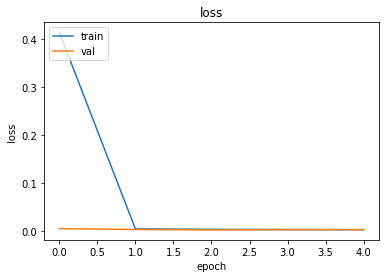

In [ ]:
report.plot_keras_metric("loss")

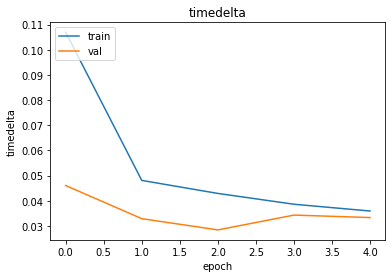

In [ ]:
report.plot_keras_metric("timedelta")

514/514 [==============================] - 4s 3ms/step


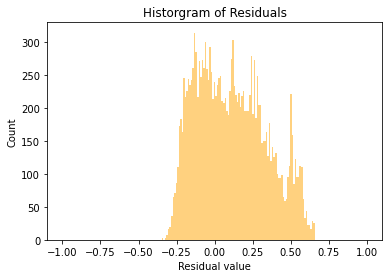

In [ ]:
y_real = np.concatenate([y for x, y in val_input], axis=0)
y_pred = model.predict(validation['Sequence'][:len(y_real)])
report.plot_residuals(y_real, y_pred, xrange=(-1, 1))

Epoch 1/5
305/305 [==============================] - 6s 21ms/step - loss: 0.0029 - mae: 0.0360 - timedelta: 0.0398
Epoch 2/5
305/305 [==============================] - 6s 20ms/step - loss: 0.0028 - mae: 0.0351 - timedelta: 0.0353
Epoch 3/5
305/305 [==============================] - 6s 20ms/step - loss: 0.0027 - mae: 0.0346 - timedelta: 0.0348
Epoch 4/5
305/305 [==============================] - 6s 20ms/step - loss: 0.0027 - mae: 0.0343 - timedelta: 0.0338
Epoch 5/5
305/305 [==============================] - 7s 22ms/step - loss: 0.0027 - mae: 0.0345 - timedelta: 0.0348


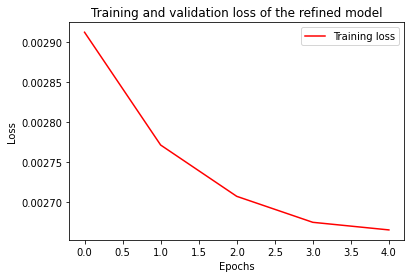

In [ ]:
history = model.fit(x=test_input, epochs=epochs, batch_size=batch_size)
import matplotlib.pyplot as plt
plt.plot(range(epochs), history.history['loss'], '-', color='r', label='Training loss')
plt.title(f'Training and validation loss of the refined model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()